In [1]:
# vs code写代码时候执行
import sys, os
sys.path.append("..")  # 跳到上级目录下面（sys.path添加目录时注意是在windows还是在Linux下，windows下需要‘\'否则会出错。）
colab_path = "."
if os.path.exists(colab_path):
    sys.path.append(colab_path)

In [2]:
# 如果你的Notebook运行时不能实时反应import的.py文件的代码变化
# 特别是当你同时在.py文件里写写改改然后在Notebook里尝试运行它的时候

# 在Notebook里添加自动重新加载
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from cfg.cfg import *

DIR_INPUT = '../datasets/'
DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"

## Extract labels about bounding box and light color from json file

In [4]:
with open("../datasets/train_dataset/train.json") as f:
    data_dict = json.load(f)
data_dict

{'annotations': [{'filename': 'train_images\\00001.jpg',
   'bndbox': {'xmin': 1026.5, 'ymin': 741.8, 'xmax': 1077.5, 'ymax': 910.9},
   'inbox': [{'color': 'red',
     'shape': '0',
     'bndbox': {'xmin': 1037.2, 'ymin': 750.8, 'xmax': 1068.6, 'ymax': 800.3},
     'occluded': 0,
     'truncated': 0,
     'difficult': 0,
     'value': -1}],
   'truncated': 0,
   'occluded': 0,
   'ignore': 0},
  {'filename': 'train_images\\00001.jpg',
   'bndbox': {'xmin': 1086.7, 'ymin': 863.1, 'xmax': 1131.3, 'ymax': 985.2},
   'inbox': [],
   'truncated': 0,
   'occluded': 0,
   'ignore': 1},
  {'filename': 'train_images\\00001.jpg',
   'bndbox': {'xmin': 969.5, 'ymin': 874.6, 'xmax': 1035.6, 'ymax': 1005.1},
   'inbox': [],
   'truncated': 0,
   'occluded': 0,
   'ignore': 1},
  {'filename': 'train_images\\00002.jpg',
   'bndbox': {'xmin': 1418.7, 'ymin': 1136.8, 'xmax': 1428.3, 'ymax': 1149.4},
   'inbox': [{'color': 'red',
     'shape': '-1',
     'bndbox': {'xmin': 1423.2,
      'ymin': 1140.4,

In [5]:
# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']
    
    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })
    

# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('../assets/data/traffic_lights.csv', index=False)

In [6]:
data_tf = pd.read_csv('../assets/data/traffic_lights.csv')

In [7]:
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('../assets/data/traffic_lights_labels.csv', index=False)

In [8]:
df = pd.read_csv('../assets/data/traffic_lights_labels.csv')
df.head()

,filename,xmin,ymin,xmax,ymax,color
0,00001.jpg,1026.5,741.8,1077.5,910.9,red
1,00002.jpg,1418.7,1136.8,1428.3,1149.4,red
2,00003.jpg,2574.3,868.7,2632.3,887.1,red
3,00003.jpg,2252.1,899.6,2300.8,918.7,green
4,00004.jpg,833.3,1163.2,843.6,1184.8,green


## Data exploration and visualization

In [9]:
df.head()

,filename,xmin,ymin,xmax,ymax,color
0,00001.jpg,1026.5,741.8,1077.5,910.9,red
1,00002.jpg,1418.7,1136.8,1428.3,1149.4,red
2,00003.jpg,2574.3,868.7,2632.3,887.1,red
3,00003.jpg,2252.1,899.6,2300.8,918.7,green
4,00004.jpg,833.3,1163.2,843.6,1184.8,green


In [10]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [11]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


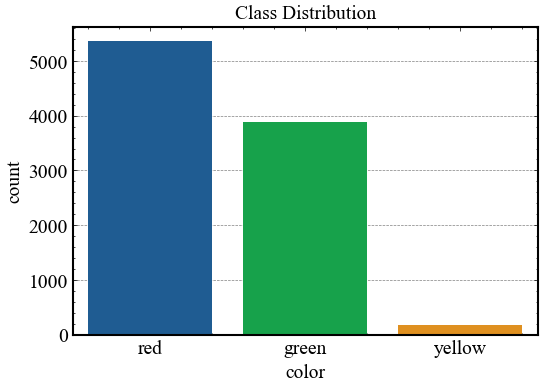

In [12]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df);

In [13]:
def plot_img(image_name):
    
    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


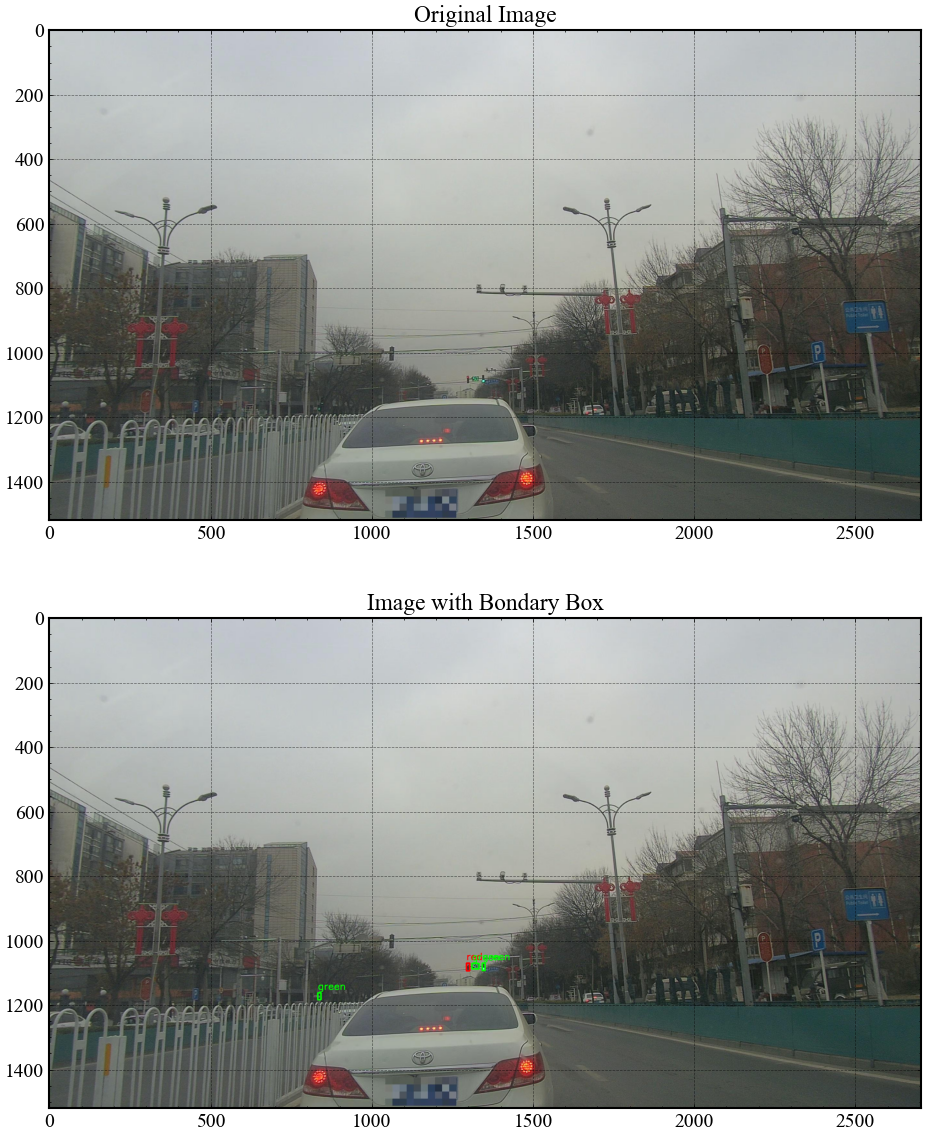

In [14]:
plot_img("00004.jpg")

## Preparing Dataset for Training

In [15]:
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [16]:
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        # Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        # Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            # Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            # Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            # Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(
                height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            # Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            # Transforms
            if self.transforms:
                image = self.transforms(image)

            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(
                height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name


In [17]:
# Preparing data for Train & Validation

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))


# Dataset object
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


# Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [18]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
device

device(type='cuda')

## Create model

In [19]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 5

## Training model

In [21]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm 
        
        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step() 

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

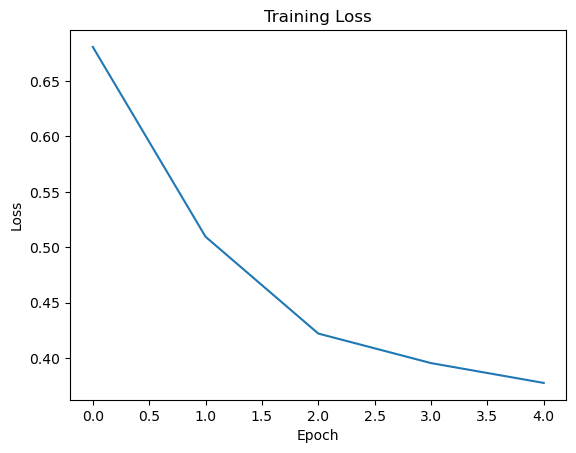

In [ ]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in tqdm(valid_data_loader):
        
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())
        
    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')
 
time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)

100%|██████████| 245/245 [00:42<00:00,  5.81it/s]

Val loss is 0.4051
Time elapsed:  42.19468450546265


In [ ]:
folder_path = "/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images"

# lấy danh sách các tệp ảnh và tạo một DataFrame trong pandas
file_names = os.listdir(folder_path)
df_test = pd.DataFrame({'filename': file_names})

In [ ]:
df_test

,filename
0,02585.jpg
1,02085.jpg
2,02880.jpg
3,02308.jpg
4,01093.jpg
...,...
395,00112.jpg
396,02765.jpg
397,01863.jpg
398,02956.jpg


In [ ]:
submission = pd.DataFrame(columns = ["filename", "xmin", "ymin", 
                                     "xmax", "ymax", "color"])
submission.head()

,filename,xmin,ymin,xmax,ymax,color


In [ ]:

# Preparing Training Data
images = os.listdir(DIR_IMAGES_TEST)

df_test = df_test.drop_duplicates(subset='filename', keep="first")

# Test Dataset
test_dataset = TrafficLightDetectionDataset(df_test, DIR_IMAGES_TEST, mode = 'test', 
                                            transforms = get_transform())

# Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
# Results - may take few mins, please wait!

threshold = 0.7
model.eval()

for images, image_names in test_data_loader:

    # Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)
    
    # Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    # Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    #Appending results to csv
    for y in range(len(boxes_th)):
        
        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * 4
        y1 = boxes_th[y][1] * 4
        x2 = boxes_th[y][2] * 4
        y2 = boxes_th[y][3] * 4
        class_name = labels_th[y]
        
        
        # Creating row for df
        row = {"filename" : image_names[0], 
               "xmin" : x1, "xmax" : x2, 
               "ymin" : y1, "ymax" : y2, 
               "color" : class_name}
        
        # Appending to df
        submission = submission.append(row, ignore_index = True)

In [ ]:
print(submission)

      filename  xmin  ymin  xmax  ymax  color
0    02880.jpg  1112  1044  1132  1088    red
1    02880.jpg   264  1008   284  1048  green
2    02880.jpg   788   908   808   944    red
3    01093.jpg  1456   864  1476   912    red
4    01093.jpg  1184   860  1204   912    red
..         ...   ...   ...   ...   ...    ...
440  01923.jpg  1492   900  1512   940  green
441  02765.jpg  1336   980  1360  1036    red
442  02956.jpg  1128   896  1208   932  green
443  02956.jpg  1324   900  1380   932  green
444  02956.jpg  2380  1000  2400  1044  green

[445 rows x 6 columns]


In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
df = pd.read_csv('/kaggle/working/submission.csv')
df.head(15)

,filename,xmin,ymin,xmax,ymax,color
0,02880.jpg,1112,1044,1132,1088,red
1,02880.jpg,264,1008,284,1048,green
2,02880.jpg,788,908,808,944,red
3,01093.jpg,1456,864,1476,912,red
4,01093.jpg,1184,860,1204,912,red
5,01093.jpg,1764,996,1776,1016,red
6,00938.jpg,992,1200,1008,1244,green
7,00938.jpg,1508,1268,1532,1316,green
8,00074.jpg,1148,592,1192,712,green
9,00074.jpg,1000,584,1044,700,green


In [ ]:
DIR_INPUT = '/kaggle/input/traffic-light-detection-dataset/'

DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"


def plot_img_test(image_name):

    fig, ax = plt.subplots(2, 1, figsize=(14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255, 0, 0)
        elif label == 'green':
            color_brg = (0, 255, 0)
        elif label == 'yellow':
            color_brg = (0, 255, 255)

        cv2.rectangle(image2, (int(x1), int(y1)),
                      (int(x2), int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1), int(y1-10)),
                    font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()


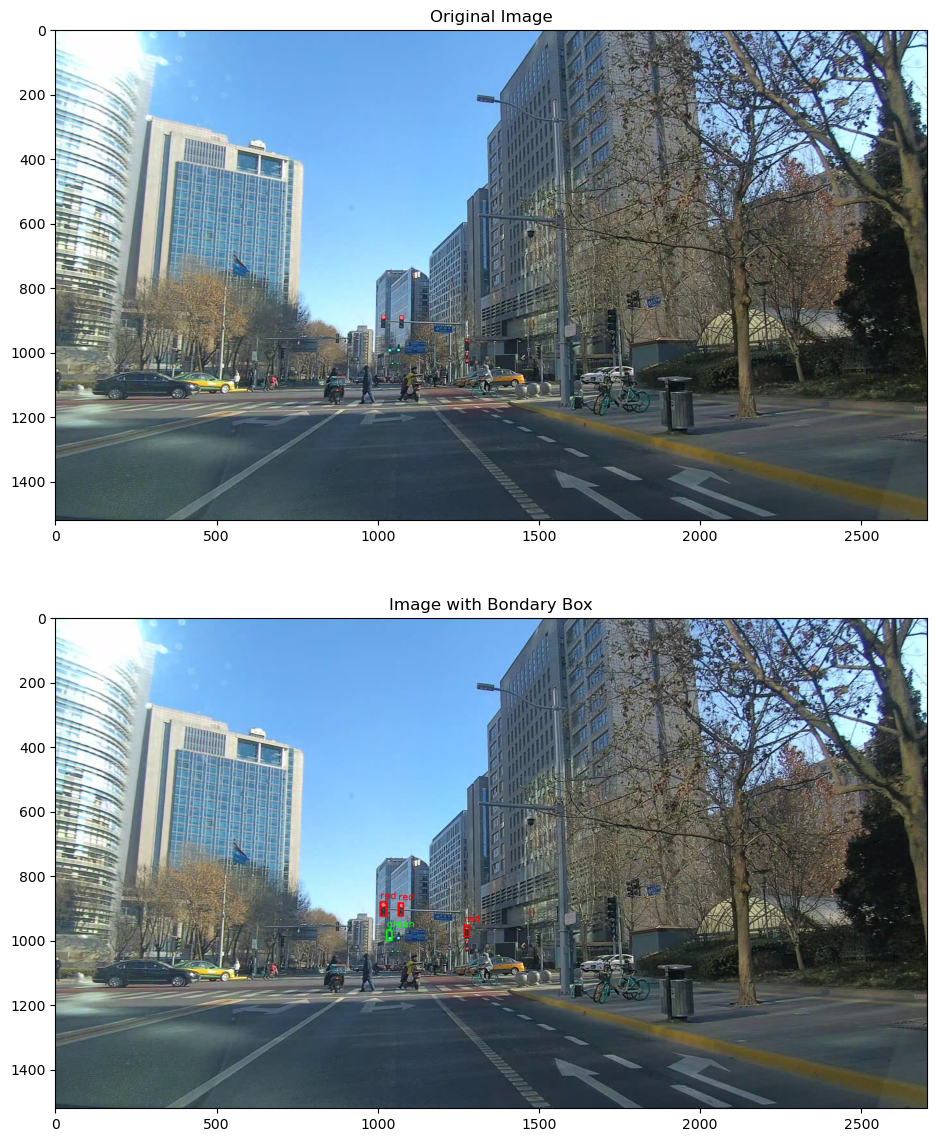

In [ ]:
plot_img_test('00069.jpg')